In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as squareform
from tqdm import tqdm


# Model
Idea: observe the effect of random CA3-CA1 projections in the case of low dimensional continuous attractor vs randomly projected high dimensional attractors


In [5]:
# place field activation funtion
def PlaceField(x,y,x_c,y_c,peak_act=1,pf_sigma=10): 
    x_off = (x-x_c)**2
    y_off = (y-y_c)**2
    pf_act = peak_act*np.exp(-(x_off+y_off)/(2*pf_sigma**2))
    return pf_act

# builds environmenr 
def BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1):
    X_Grid, Y_Grid = np.meshgrid(np.arange(0,L,Samp_Dens),np.arange(0,L,Samp_Dens)) 
    
    CA3_X = np.linspace(0,L,int(L/CA3_Dens)+1) 
    CA3_X = (CA3_X[0:-1]+CA3_X[1:])/2
    
    X_Pf , Y_Pf = np.meshgrid(CA3_X,CA3_X)
    
    return X_Grid, Y_Grid, X_Pf, Y_Pf, X_Pf.size

def Connections_Init(N_CA3,N_CA1):
    Conn = np.random.rand(N_CA3,N_CA1)
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    return Conn

def Compute_Sparsity(Vec):
    sp = (np.mean(Vec))**2/np.mean(Vec**2)
    return sp


def Normalize_Activity(Act,m_trgt=1,s_trgt=0.1):
    s = 1
    thr = np.mean(Act)
    thr_u = np.max(Act)
    thr_d = np.min(Act)
    cc = 0
    while np.abs(s-s_trgt)>0.01:
        Act_thr = Act - thr
        Act_thr[Act_thr<0] = 0

        s = Compute_Sparsity(Act_thr)
        dec_s = np.sign(s-s_trgt)
        if dec_s==1:
            thr_d,thr,thr_u = [thr, (thr_u+thr_d)/2, thr_u]
        else:
            thr_d,thr,thr_u = [thr_d, (thr_u+thr_d)/2, thr]
        cc = cc + 1
        if(cc>1000):
            break
            
    Act_thr = Act_thr/np.mean(Act_thr)*m_trgt
    return Act_thr

def Normalize_Activity1(Act,sparsity=0.1):
    th = np.percentile(Act,(1.0-sparsity)*100)
    Act = Act-th
    Act[Act<0] = 0
    Act = Act/np.mean(Act)
    return Act

def Compute_Plasticity(Pre,Post,eta=0.001):
    dw = Pre @ ((Post-np.mean(Post,axis=0)).T)
    dw = dw * eta
    return dw

def Apply_Plasticity(Conn,dw_tot):
    Conn += dw_tot
    Conn[Conn<0] = 0
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    Conn[np.isnan(Conn)] = 0
    return Conn

def Add_Noise(vector,sigma):
    vector += np.random.uniform(-sigma,sigma,size = vector.shape)
    return vector




# With learning

In [6]:
eta_l = 0.0001 # LEARNING RATE
n_rounds = 10 # AMOUNT OF LEARNING
sigma = 0.5

CA1_corr = []

sparsitites = [0.4] #[0.01,0.05,0.1,0.2,0.3,0.4,0.6,0.8]

for spars in sparsitites:
    print(f"Computing spastity {spars} ... ")
    
    # TRAINING

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3
    Conn = Connections_Init(N_CA3,N_CA1)

    for l_round in range(n_rounds):
        dw_tot = 0
        #swipes the envirronment
        for zz in tqdm(range(XY_Coor.shape[0])):
            Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
            Act_XY = Add_Noise(Act_XY,sigma=sigma)
            CA1_Act = Act_XY@Conn
            CA1_Time = Normalize_Activity1(CA1_Act,sparsity=spars)

            Pre = Act_XY[:,np.newaxis]
            Post = CA1_Time[:,np.newaxis]

            dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

        Conn = Apply_Plasticity(Conn,dw_tot)

    # TESTING

    

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=10)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3


    CA1_Out = np.zeros((XY_Coor.shape[0],N_CA1)) 
    for zz in range(XY_Coor.shape[0]):
        Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
        CA1_Act = Act_XY@Conn


        CA1_Out[zz,:] = Normalize_Activity1(CA1_Act,sparsity=spars)


    CA1_DD = 1 - pdist(CA1_Out,metric='correlation')
    CA1_corr.append(CA1_DD)

CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
for zz in range(XY_Coor.shape[0]):
    CA3_Out[zz,:] = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
CA3_DD = 1 - pdist(CA3_Out,metric='correlation')

  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity 0.01 ... 


100%|██████████| 10000/10000 [00:02<00:00, 3768.97it/s]
<ipython-input-5-719d5bd0595d>:67: RuntimeWarning: invalid value encountered in true_divide
  Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
  0%|          | 0/10000 [00:00<?, ?it/s]

Computing spastity 0.05 ... 


 44%|████▍     | 4396/10000 [00:01<00:01, 3617.15it/s]


KeyboardInterrupt: 

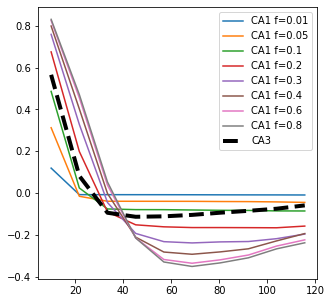

In [75]:
from scipy.stats import binned_statistic

plt.figure(figsize=(5,5))

for i,CA1_DD in enumerate(CA1_corr):
    y,bins,_ = binned_statistic(XY_DD,CA1_DD,statistic='mean',bins=10)
    plt.plot(bins[:-1],y,label=f'CA1 f={sparsitites[i]}')


y,bins,_ = binned_statistic(XY_DD,CA3_DD,statistic='mean',bins=10)
plt.plot(bins[:-1],y,c='k',label='CA3',linewidth=4,linestyle='--')

plt.legend()




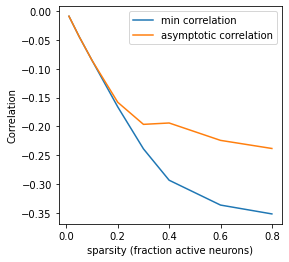

In [76]:
plt.figure(figsize=(4,4))
plt.xlabel("sparsity (fraction active neurons)")
plt.ylabel("Correlation")
binned_corr = []
for i,CA1_DD in enumerate(CA1_corr):
    binned_corr.append(binned_statistic(XY_DD,CA1_DD,statistic='mean',bins=10)[0])

min_corr_l = [min(i) for i in binned_corr]
asymptotic_corr_l = [i[-1] for i in binned_corr]

plt.plot(sparsitites,min_corr_l,label='min correlation')
plt.plot(sparsitites,asymptotic_corr_l,label='asymptotic correlation')

plt.legend()


(-0.5, 9.5, -0.5, 9.5)

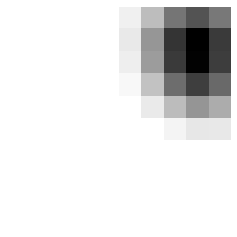

In [77]:
plt.matshow(Conn[:,0].reshape(X_Grid.shape),origin='lower',cmap=plt.cm.Greys)
plt.axis('off')

# Without leanring

In [78]:
eta_l = 0.0001 # LEARNING RATE
n_rounds = 0 # AMOUNT OF LEARNING

CA1_corr = []

sparsitites = [0.01,0.05,0.1,0.2,0.3,0.4,0.6,0.8]

for spars in sparsitites:
    print(f"Computing spastity {spars} ... ")
    
    # TRAINING

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=1)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3
    Conn = Connections_Init(N_CA3,N_CA1)

    for l_round in range(n_rounds):
        dw_tot = 0
        #swipes the envirronment
        for zz in tqdm(range(XY_Coor.shape[0])):
            Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
            CA1_Act = Act_XY@Conn


            CA1_Time = Normalize_Activity1(CA1_Act,sparsity=spars)

            Pre = Act_XY[:,np.newaxis]
            Post = CA1_Time[:,np.newaxis]

            dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

        Conn = Apply_Plasticity(Conn,dw_tot)

    # TESTING

    

    X_Grid, Y_Grid, X_Pf, Y_Pf, N_CA3 = BuildEnvironment(L=100,CA3_Dens=10,Samp_Dens=10)
    XY_Coor = np.vstack((X_Grid.flatten(), Y_Grid.flatten())).T 
    XY_DD = pdist(XY_Coor)
    N_CA1 = N_CA3 * 3


    CA1_Out = np.zeros((XY_Coor.shape[0],N_CA1)) 
    for zz in range(XY_Coor.shape[0]):
        Act_XY = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
        CA1_Act = Act_XY@Conn


        CA1_Out[zz,:] = Normalize_Activity1(CA1_Act,sparsity=spars)


    CA1_DD = 1 - pdist(CA1_Out,metric='correlation')
    CA1_corr.append(CA1_DD)

CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
for zz in range(XY_Coor.shape[0]):
    CA3_Out[zz,:] = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
CA3_DD = 1 - pdist(CA3_Out,metric='correlation')

Computing spastity 0.01 ... 
Computing spastity 0.05 ... 
Computing spastity 0.1 ... 
Computing spastity 0.2 ... 
Computing spastity 0.3 ... 
Computing spastity 0.4 ... 
Computing spastity 0.6 ... 
Computing spastity 0.8 ... 


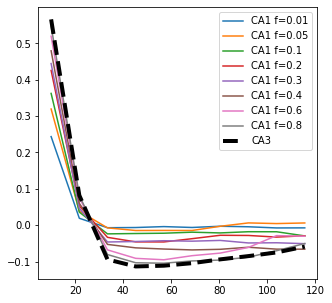

In [79]:
from scipy.stats import binned_statistic

plt.figure(figsize=(5,5))

for i,CA1_DD in enumerate(CA1_corr):
    y,bins,_ = binned_statistic(XY_DD,CA1_DD,statistic='mean',bins=10)
    plt.plot(bins[:-1],y,label=f'CA1 f={sparsitites[i]}')


y,bins,_ = binned_statistic(XY_DD,CA3_DD,statistic='mean',bins=10)
plt.plot(bins[:-1],y,c='k',label='CA3',linewidth=4,linestyle='--')

plt.legend()

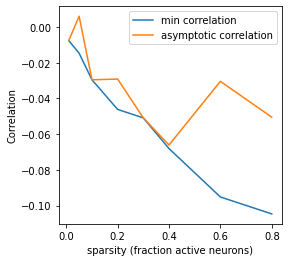

In [80]:
plt.figure(figsize=(4,4))
plt.xlabel("sparsity (fraction active neurons)")
plt.ylabel("Correlation")
binned_corr = []
for i,CA1_DD in enumerate(CA1_corr):
    binned_corr.append(binned_statistic(XY_DD,CA1_DD,statistic='mean',bins=10)[0])

min_corr_nl = [min(i) for i in binned_corr]
asymptotic_corr_nl = [i[-1] for i in binned_corr]

plt.plot(sparsitites,min_corr_nl,label='min correlation')
plt.plot(sparsitites,asymptotic_corr_nl,label='asymptotic correlation')

plt.legend()


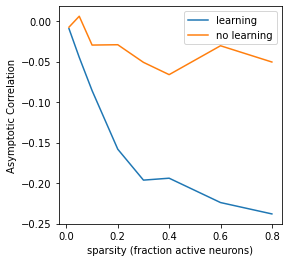

In [82]:
plt.figure(figsize=(4,4))
plt.xlabel("sparsity (fraction active neurons)")
plt.ylabel("Asymptotic Correlation")

plt.plot(sparsitites,asymptotic_corr_l,label='learning')
plt.plot(sparsitites,asymptotic_corr_nl,label='no learning')

plt.legend()
